In [4]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
from utils import *
from sub_act import sub_input, sub_process
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
sns.set(style='ticks', font_scale=1.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system

vol_file = Path('depreciated/analysis_sections_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

## Quantifying subthreshold inputs

In [10]:
k_ = boxcarKernel(sigma=1)
inh_low = []
inh_high = []
exc_low = []
exc_high = []
is_break = False
for _, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    if 'Social' in row['task']:
        continue
    if 'Optovin' in row['task']:
        continue
#     if 'memory' not in row['task']:
#         continue

    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    # spk with padding zeros for the first 2 seconds
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    subvolt = sub_process(dff, k_size=11)
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

    _ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    task_period = _['task_period']
    swim_task_index = _['swim_task_index']
    
    for n_cell in range(subvolt.shape[0]):
        sub_list = np.zeros((r_swim.shape[0], 400))
        remove_list = np.zeros(r_swim.shape[0]).astype('bool')
        for n, n_swim in enumerate(swim_starts):
            try:
                sub_list[n, :] = subvolt[n_cell, n_swim-100:n_swim+300] 
            except:
                remove_list[n]=True
        task_period_ = task_period.copy()
        task_period_[remove_list] = 0
        inh, exc = sub_input(sub_list[task_period_==1, :]*100)
        inh_low.append(inh)
        exc_low.append(exc)
        inh, exc = sub_input(sub_list[task_period_==2, :]*100)
        inh_high.append(inh)
        exc_high.append(exc)

In [14]:
inh_low = np.array(inh_low)
exc_low = np.array(exc_low)

inh_high = np.array(inh_high)
exc_high = np.array(exc_high)

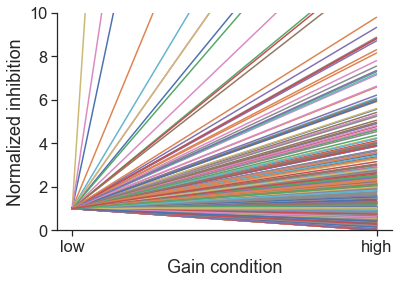

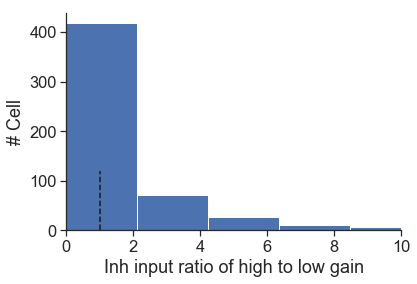

[278, 544]


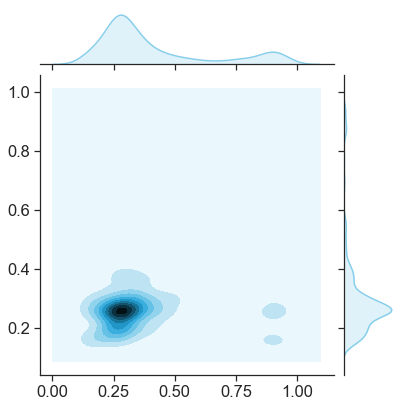

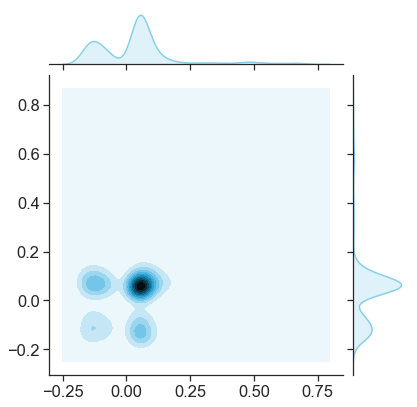

In [15]:
valid_ = inh_low[:,-1]<np.percentile(inh_low[:,-1], 99)
plt.plot(['low', 'high'], [inh_low[valid_,-1]/inh_low[valid_,-1], inh_high[valid_,-1]/inh_low[valid_,-1]])
plt.ylabel('Normalized inhibition')
plt.xlabel('Gain condition')
plt.ylim([0, 10])
sns.despine()
plt.show()

plt.hist(inh_high[valid_,-1]/inh_low[valid_,-1], bins=100)
plt.vlines([1], [0], [120], linestyles='--', color='k')
plt.ylabel('# Cell')
plt.xlabel('Inh input ratio of high to low gain')
plt.xlim([0, 10])
sns.despine()
plt.show()
print([np.sum(inh_high[valid_,-1]/inh_low[valid_,-1]<=1), valid_.sum()])

# plt.plot(inh_low[valid_,1]-inh_high[valid_,1], inh_high[valid_,-1]/inh_low[valid_,-1], '.')
# plt.ylabel('Normalized inhibition')
# plt.xlabel('Gain condition')
# plt.ylim([0, 5])
# sns.despine()
# plt.show()

sns.jointplot(x=inh_low[valid_,1], y=inh_high[valid_,1], kind='kde', color="skyblue")
plt.show()

sns.jointplot(x=inh_low[:,0], y=inh_high[:,0], kind='kde', color="skyblue")
plt.show()

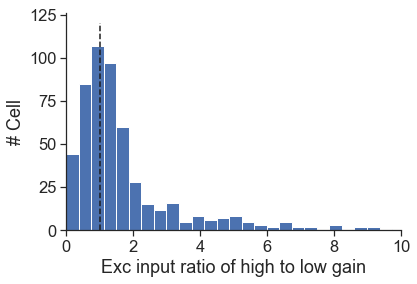

[193, 545]


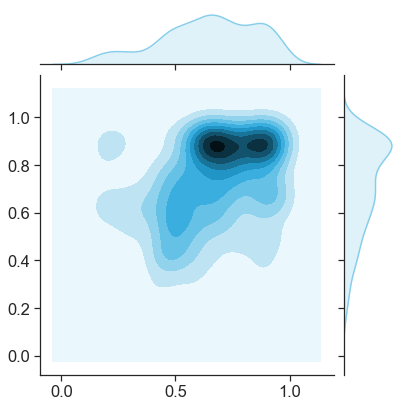

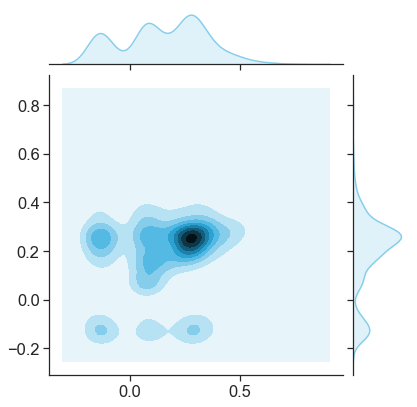

In [16]:
valid_ = exc_low[:,-1]>np.percentile(exc_low[:,-1], 1)
# plt.plot(['low', 'high'], [exc_low[valid_,-1]/exc_low[valid_,-1], exc_high[valid_,-1]/exc_low[valid_,-1]])
# plt.ylabel('Normalized inhibition')
# plt.xlabel('Gain condition')
# plt.ylim([0, 10])
# sns.despine()
# plt.show()
plt.hist(exc_high[valid_,-1]/exc_low[valid_,-1], bins=100)
plt.vlines([1], [0], [120], linestyles='--', color='k')
plt.ylabel('# Cell')
plt.xlabel('Exc input ratio of high to low gain')
plt.xlim([0, 10])
sns.despine()
plt.show()
print([np.sum(exc_high[valid_,-1]/exc_low[valid_,-1]<=1), valid_.sum()])

# plt.plot(inh_low[valid_,1]-inh_high[valid_,1], inh_high[valid_,-1]/inh_low[valid_,-1], '.')
# plt.ylabel('Normalized inhibition')
# plt.xlabel('Gain condition')
# plt.ylim([0, 5])
# sns.despine()
# plt.show()

sns.jointplot(x=exc_low[valid_,1], y=exc_high[valid_,1], kind='kde', color="skyblue")
plt.show()

sns.jointplot(x=exc_low[:,0], y=exc_high[:,0], kind='kde', color="skyblue")
plt.show()